## Analysis of Locations

The aim of this notebook is to analyze the results we got with the Machine Learning models by locations. We want to display the results on the map and look into details into some of the locations to see what the difference between good performing and bad performing locations is 

### Import Relevant Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump, load

In [2]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
display(df.head())

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [3]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.2,random_state=4)

In [5]:
#Function to display accuracy, preicison, recall, f1 scores by locations
def location_scores(sampler, classifier):
    locations = df.Location.unique()
    region_models = {}
    results = []

    for location in locations:
        region_data = df[df['Location'] == location]
        X_loc = region_data.drop(['RainTomorrow', 'Location', 'Date'], axis=1)
        y_loc = region_data['RainTomorrow']
        X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X_loc, y_loc, test_size=0.2, random_state=42)
        
        X_sample,y_sample= sampler.fit_resample(X_train_loc,y_train_loc)
    
        #Train Classifier for each region
        classifier.fit(X_sample, y_sample)
        region_models[location] = classifier
    
        #Score for each region
        y_pred_loc = classifier.predict(X_test_loc)
        accuracy = accuracy_score(y_test_loc, y_pred_loc)
        precision = precision_score(y_test_loc, y_pred_loc)
        recall = recall_score(y_test_loc, y_pred_loc)
        f1 = f1_score(y_test_loc, y_pred_loc)
        
        results.append({
            'Location': location,
            'Accuracy': round(accuracy, 2),
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1': round(f1, 2)
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [6]:
#function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(test, pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

In [7]:
#function for train_test_split best location 
def best_location_train_test_split(best_locations):
    
    #create best location data frame
    df_best_loc = df[df.Location.isin(best_locations.Location)]
    
    #define data and target with best locations data frame
    data_best = df_best_loc.drop(columns=['RainTomorrow', 'Location', 'Date'])
    target_best = df_best_loc['RainTomorrow']
    
    #train_test_split
    X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(data_best,target_best,test_size=0.2,random_state=4)
    return X_train_best, X_test_best, y_train_best, y_test_best

### Display locations on a map 

In [8]:
df.sort_values(by='Location').Location.unique()

array(['AliceSprings', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
       'CoffsHarbour', 'Darwin', 'Hobart', 'MelbourneAirport', 'Mildura',
       'Moree', 'MountGambier', 'NorfolkIsland', 'Nuriootpa',
       'PerthAirport', 'Portland', 'Sale', 'SydneyAirport', 'Townsville',
       'WaggaWagga', 'Watsonia', 'Williamtown', 'Woomera'], dtype=object)

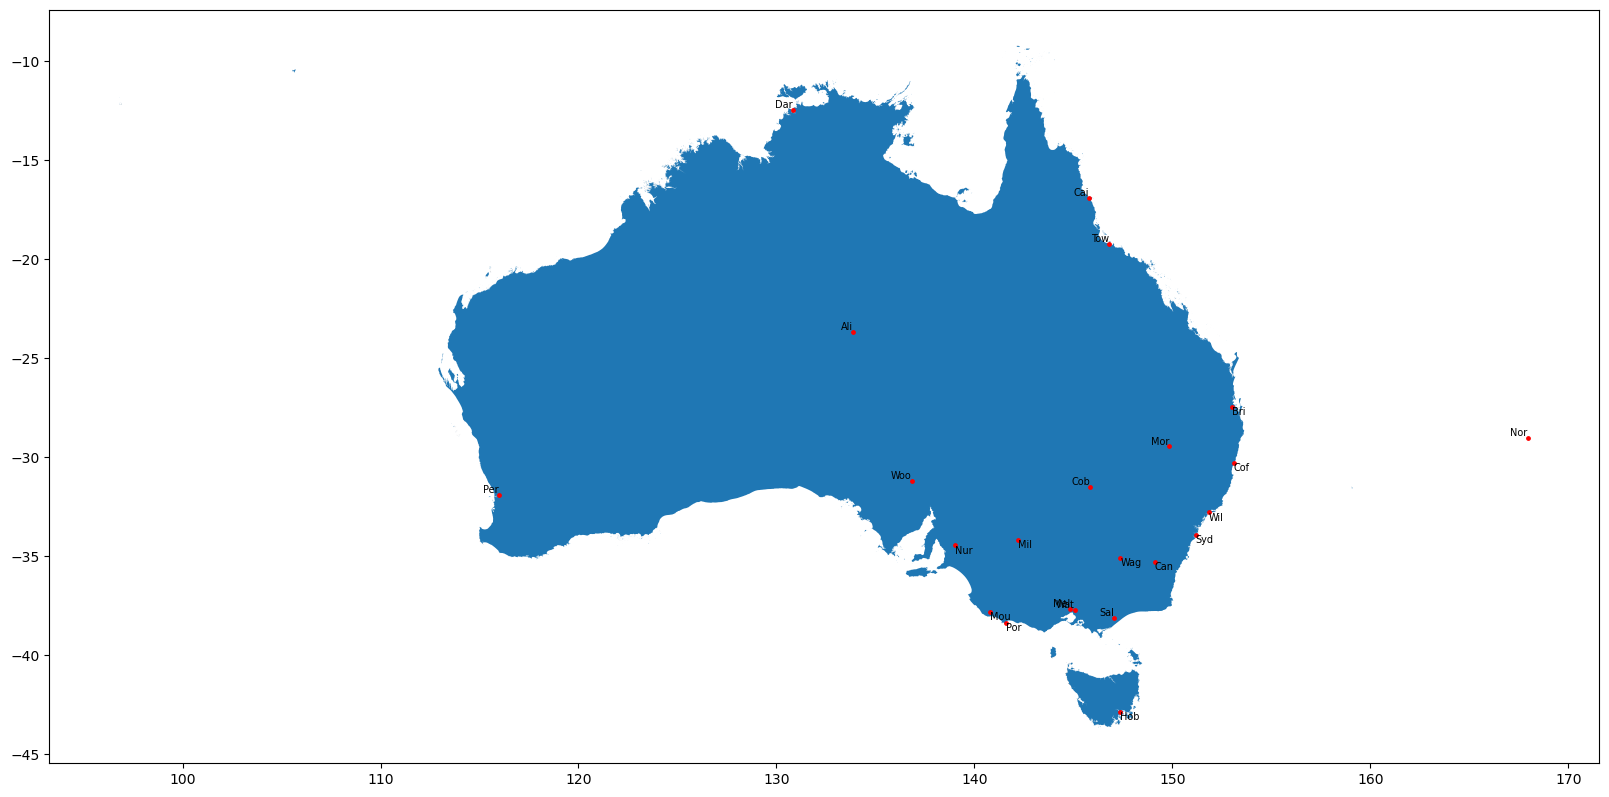

In [9]:
cities = df.Location.unique()

# Empty list to store coordinates
coordinates = [
     (-23.698, 133.8816, 'Alice Springs'),
     (-27.4689682, 153.0234991, 'Brisbane'),
     (-16.9206, 145.7709, 'Cairns'),
     (-35.2975906, 149.1012676, 'Canberra'),
     (-31.4983333, 145.8347222, 'Cobar'),
     (-30.296241, 153.113529, 'Coffs Harbour'),
     (-12.4628, 130.8417, 'Darwin'),
     (-42.8825, 147.33, 'Hobart'),
     (-37.6697, 144.8491, 'Melbourne Airport'),
     (-34.2029, 142.2202, 'Mildura'),
     (-29.4648, 149.8415, 'Moree'),
     (-37.8284, 140.7801, 'Mount Gambier'),
     (-29.0283, 167.948, 'Norfolk Island'),
     (-34.4683, 138.9958, 'Nuriootpa'),
     (-31.9374, 115.9665, 'Perth Airport'),
     (-38.3635, 141.6053, 'Portland'),
     (-38.1075, 147.0636, 'Sale'),
     (-33.9399227, 151.1752769, 'Sydney Airport'), 
     (-19.2569391, 146.8239536, 'Townsville'),
     (-35.115, 147.3677778, 'Wagga Wagga'),
     (-37.7108, 145.0833, 'Watsonia'),
     (-32.7986, 151.842, 'Williamtown'),
     (-31.1994, 136.8254, 'Woomera')]


# Path to the shapefile
shapefile_path = "../../Data/map/AUS_2021_AUST_GDA2020.shp"


# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Convert coordinates to GeoDataFrame
gdf_coordinates = gpd.GeoDataFrame(geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

# Plot the shapefile
ax = gdf.plot(figsize=(20, 20))

# Plot the coordinates
gdf_coordinates.plot(ax=ax, color='red', marker='o', markersize=6)

# Annotate the points with names
counter = 0
for x, y, name in coordinates:
    counter += 1
    ha = 'left' if counter % 2 == 0 else 'right'
    # Alternate vertical alignment
    va = 'top' if counter % 2 == 0 else 'bottom'
    ax.text(y, x,name[:3],fontsize=7, ha=ha, va=va)

### 1. Map Visualization KNN with Random Undersampling

In [10]:
rus = RandomUnderSampler()

In [11]:
knn = KNeighborsClassifier(n_neighbors=23, metric="manhattan")

In [12]:
df_knn_loc = location_scores(rus, knn)

In [13]:
#Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_knn_loc = gpd.GeoDataFrame(df_knn_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 1.1 Visualization of KNN Model Accuracy

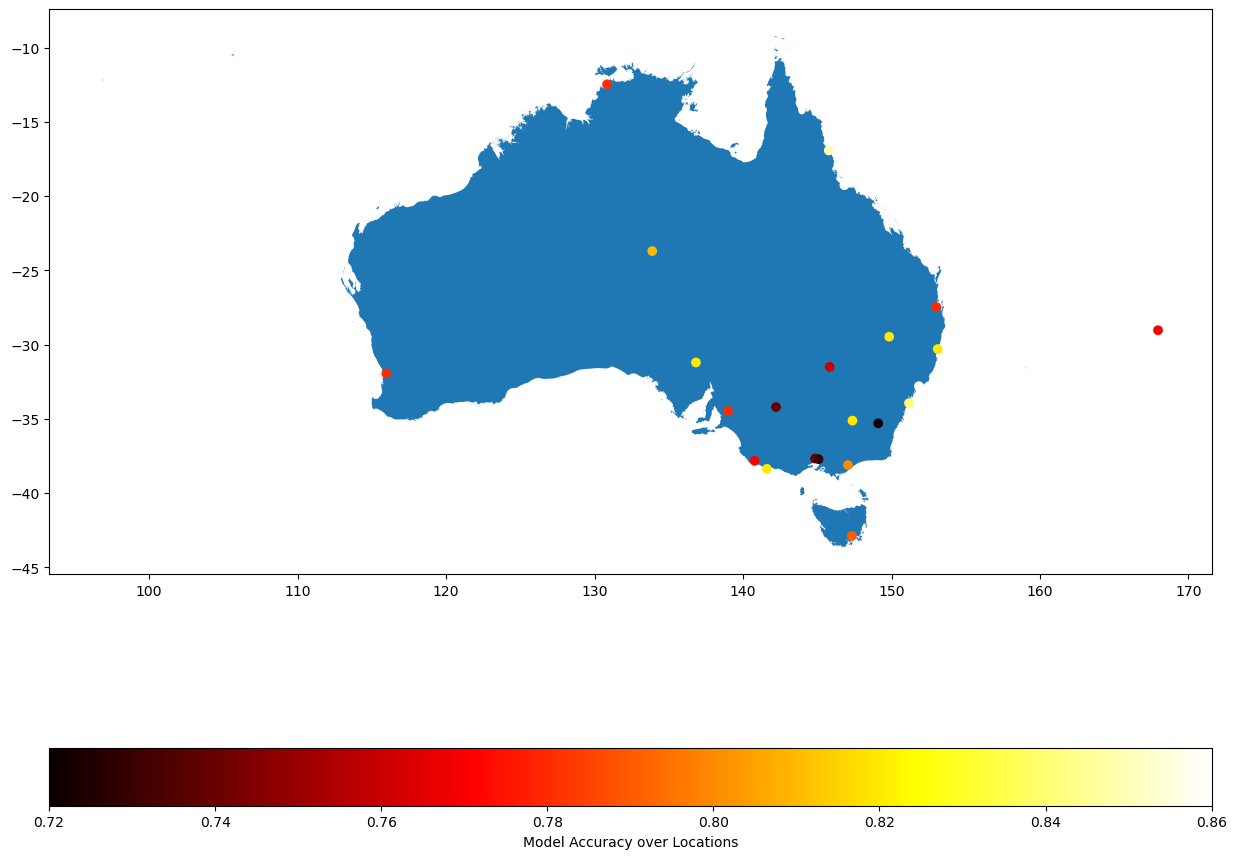

In [14]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 1.2 Visualization of KNN Precision Score 

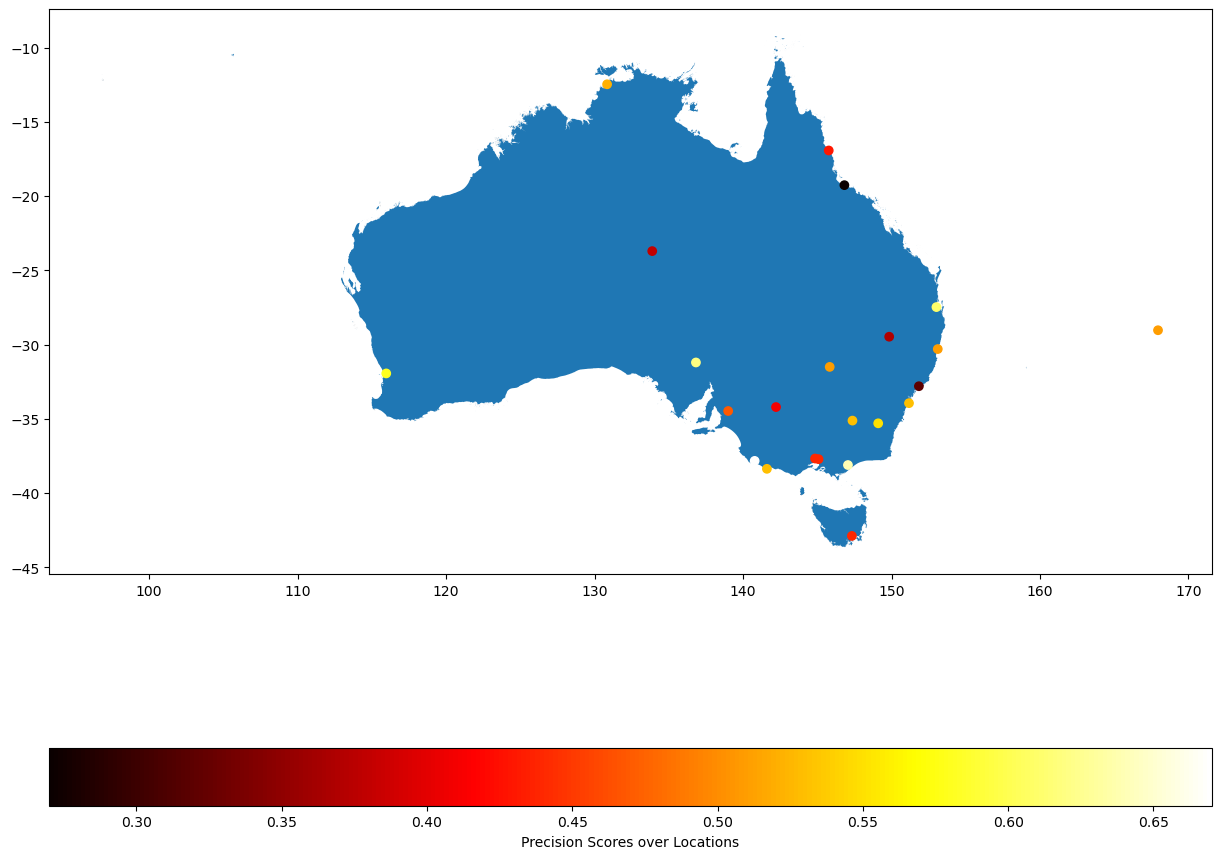

In [15]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 1.3 Visualization of KNN Recall Score

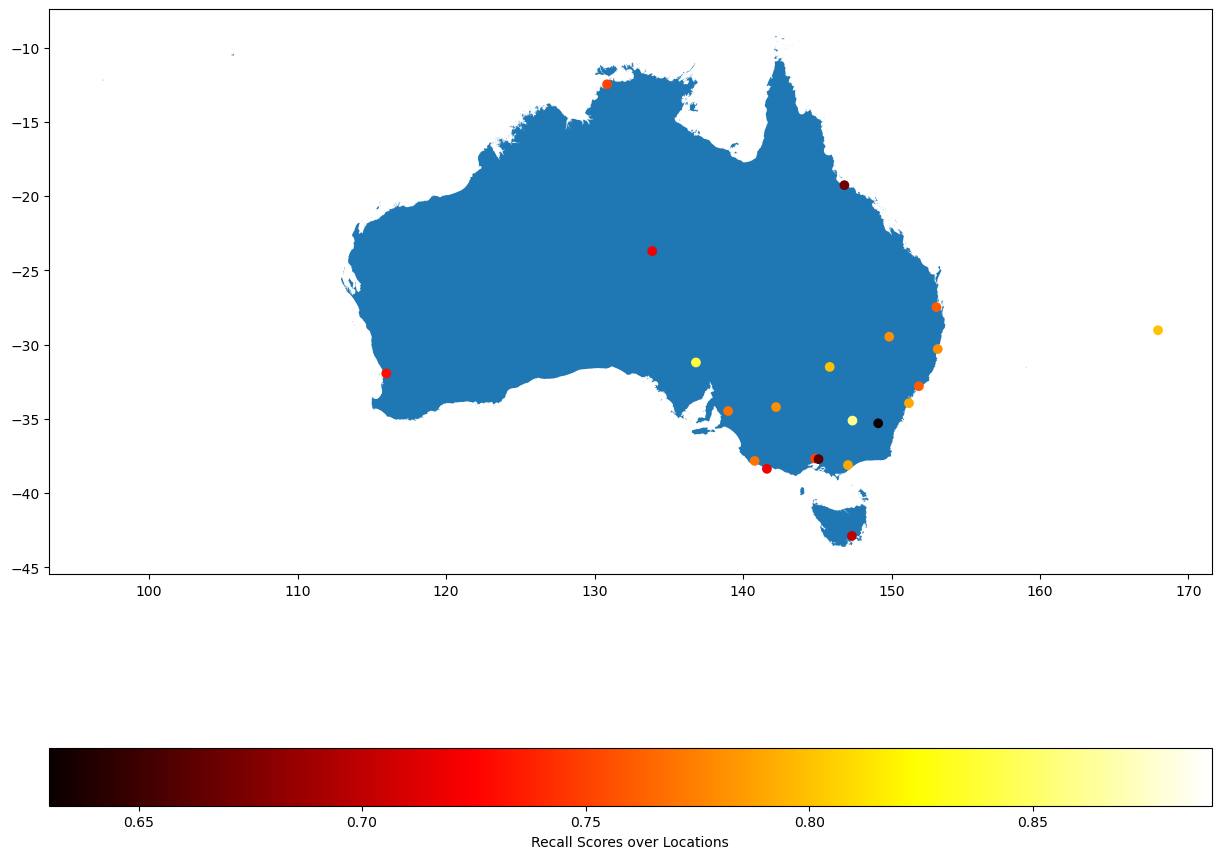

In [16]:
ax = gdf.plot(figsize=(15, 15))

results_knn_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 1.4 Analysis for locations with best accuracy scores 

In [17]:
best_locations = results_knn_loc[results_knn_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [18]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [19]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

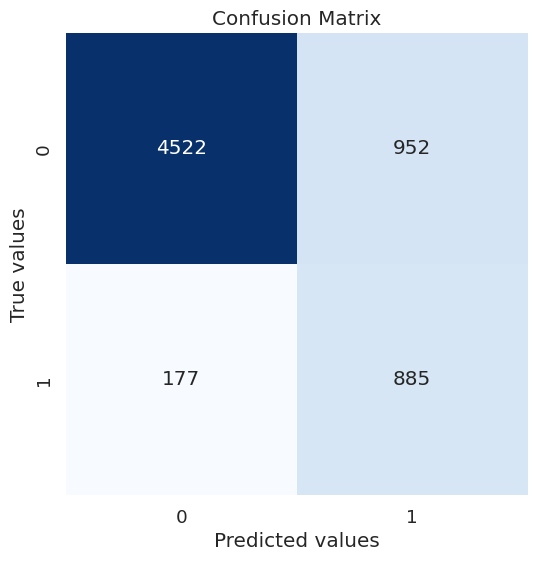

-------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      5474
         1.0       0.48      0.83      0.61      1062

    accuracy                           0.83      6536
   macro avg       0.72      0.83      0.75      6536
weighted avg       0.88      0.83      0.84      6536

-------------------------
Accuracy Train Set: 0.835 Accuracy Test Set: 0.827


In [20]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

### 1.5 Analysis for locations with best precision scores 

In [21]:
best_locations = results_knn_loc[results_knn_loc.Precision >= 0.60]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [22]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [23]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

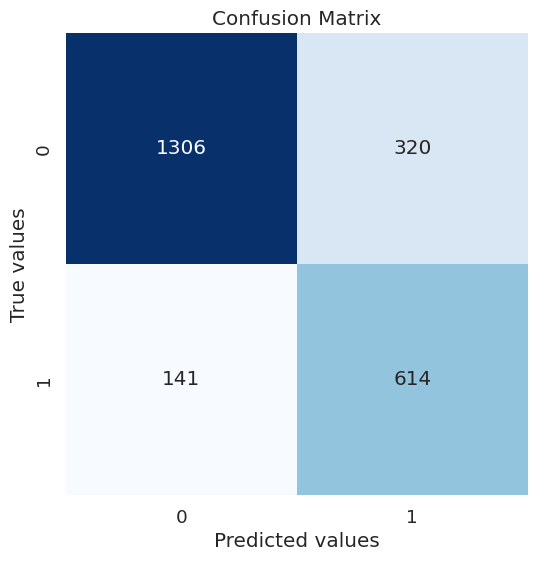

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      1626
         1.0       0.66      0.81      0.73       755

    accuracy                           0.81      2381
   macro avg       0.78      0.81      0.79      2381
weighted avg       0.82      0.81      0.81      2381

-------------------------
Accuracy Train Set: 0.802 Accuracy Test Set: 0.806


In [24]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

### 1.6 Analysis for locations with best recall scores

In [25]:
best_locations = results_knn_loc[results_knn_loc.Recall >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [26]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [27]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

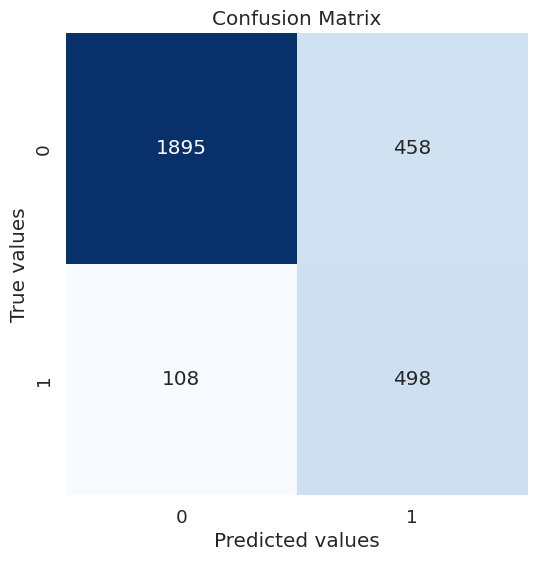

-------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      2353
         1.0       0.52      0.82      0.64       606

    accuracy                           0.81      2959
   macro avg       0.73      0.81      0.75      2959
weighted avg       0.86      0.81      0.82      2959

-------------------------
Accuracy Train Set: 0.806 Accuracy Test Set: 0.809


In [28]:
y_pred_knn = knn.predict(X_test_best)
y_pred_train_knn = knn.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_knn, y_train_best, y_pred_train_knn)

-------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.85     10663
         1.0       0.50      0.80      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.79      0.80     13545

-------------------------
Accuracy Train Set: 0.801 Accuracy Test Set: 0.79

### 2.Map Visualization Decision Tree SMOTE, best parameter and adaptive boosting

In [29]:
sm = SMOTE()

In [30]:
dt_ac_fit = load('dt_ac_fit.joblib')

In [31]:
df_dt_loc = location_scores(sm, dt_ac_fit)

In [32]:
# Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_dt_loc = gpd.GeoDataFrame(df_dt_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 2.1 Visualization Decision Tree Model Accuracy

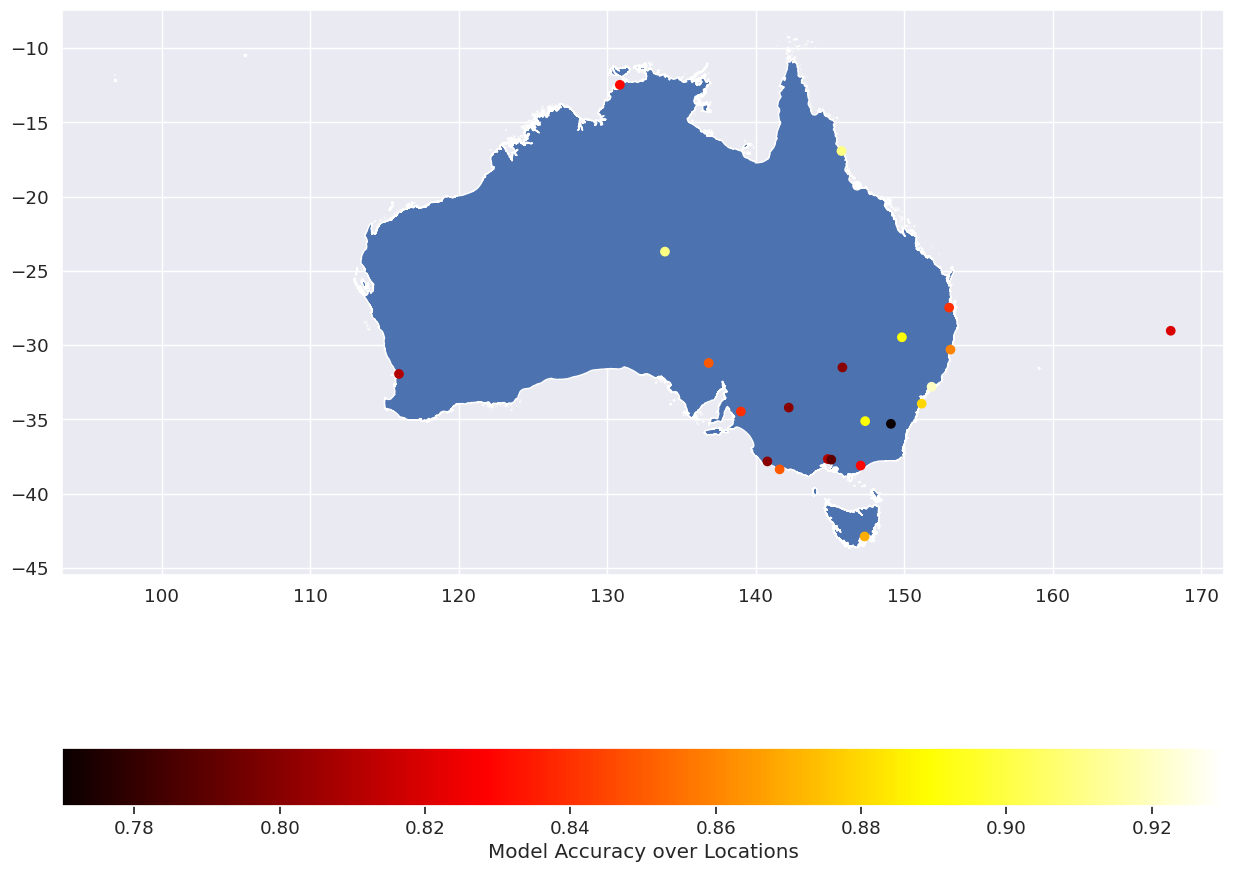

In [33]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 2.2 Visualization Decision Tree Precision Score

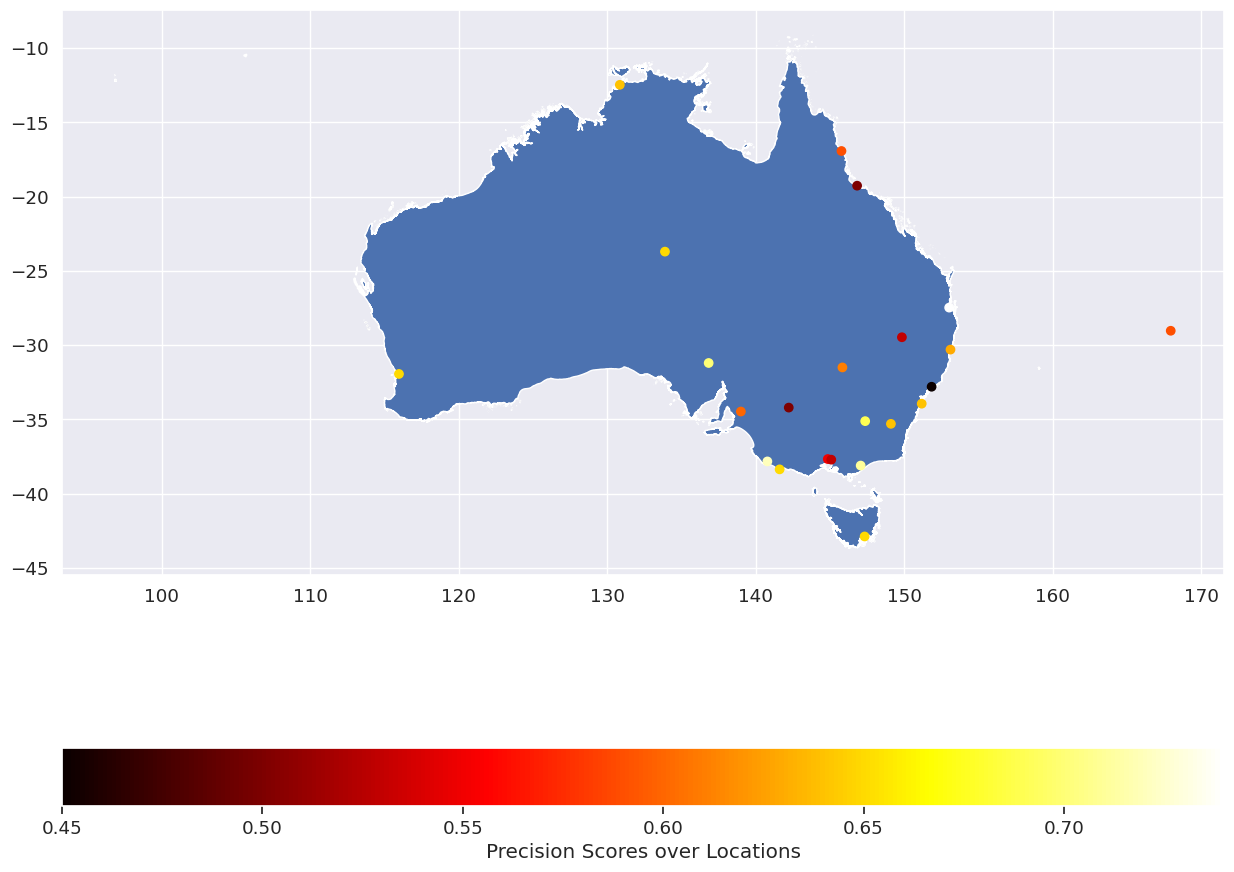

In [34]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 2.3 Visualization Decision Tree Recall Score

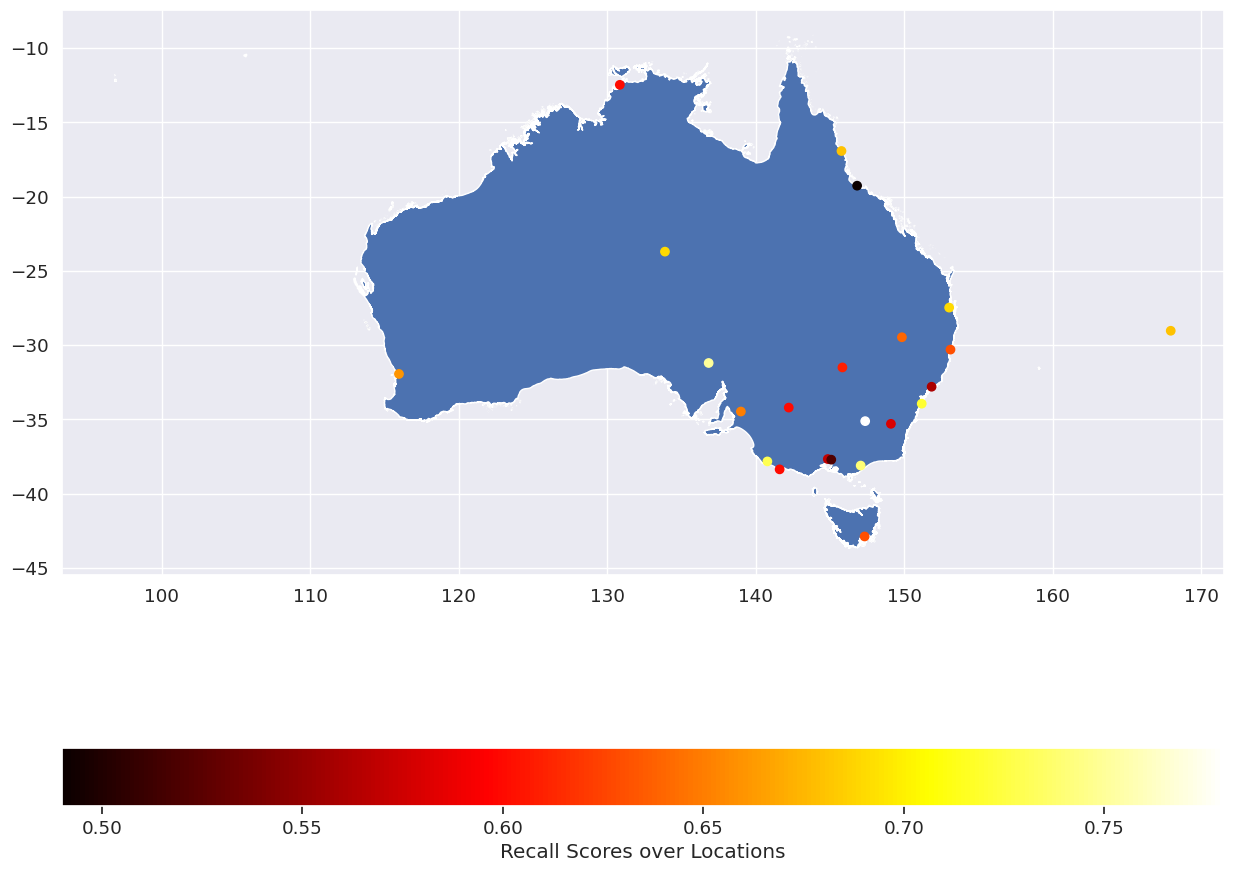

In [35]:
ax = gdf.plot(figsize=(15, 15))

results_dt_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 2.4 Analysis for locations with best accuracy socres

In [36]:
best_locations = results_dt_loc[results_dt_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [37]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [38]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

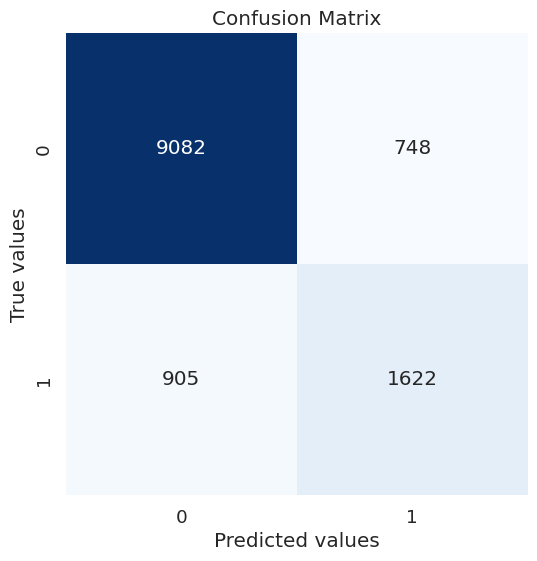

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      9830
         1.0       0.68      0.64      0.66      2527

    accuracy                           0.87     12357
   macro avg       0.80      0.78      0.79     12357
weighted avg       0.86      0.87      0.86     12357

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.866


In [39]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### 2.5 Analysis for locations with best precision scores 

In [40]:
best_locations = results_dt_loc[results_dt_loc.Precision >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [41]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [42]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

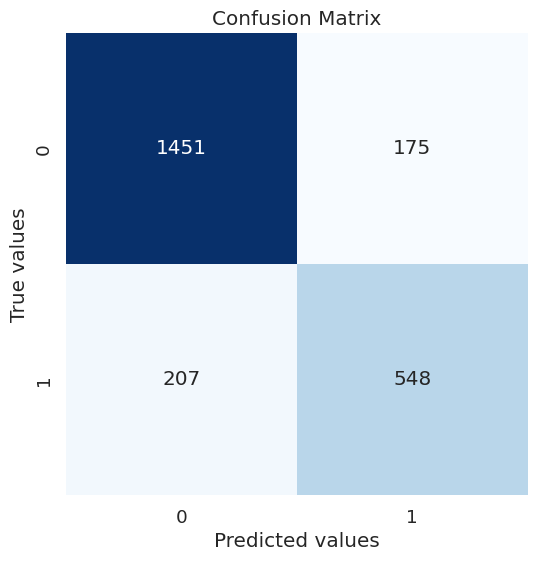

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88      1626
         1.0       0.76      0.73      0.74       755

    accuracy                           0.84      2381
   macro avg       0.82      0.81      0.81      2381
weighted avg       0.84      0.84      0.84      2381

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.84


In [43]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### 2.6 Analysis for locations with best recall scores 

In [44]:
best_locations = results_dt_loc[results_dt_loc.Recall >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [45]:
X_resampled,y_resampled = sm.fit_resample(X_train_best,y_train_best)

In [46]:
dt_ac_fit.fit(X_resampled,y_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=11,
                                                         random_state=42),
                   n_estimators=400)

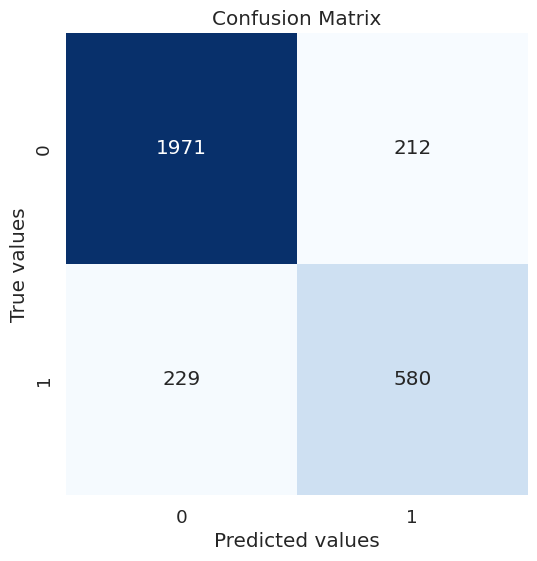

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      2183
         1.0       0.73      0.72      0.72       809

    accuracy                           0.85      2992
   macro avg       0.81      0.81      0.81      2992
weighted avg       0.85      0.85      0.85      2992

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.853


In [47]:
y_pred_ac = dt_ac_fit.predict(X_test_best)
y_pred_train_ac = dt_ac_fit.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_ac, y_train_best, y_pred_train_ac)

### Best results for all locations (from Decision Tree Modelling Notebook)

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91     10663
         1.0       0.69      0.64      0.66      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.78      0.79     13545
weighted avg       0.86      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.861

### 3. Map Visualization Random Forest Classifier with Random Oversampling

In [48]:
ros = RandomOverSampler()

In [49]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=321)

In [50]:
df_rfc_loc = location_scores(ros, rfc)

In [51]:
# Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_rfc_loc = gpd.GeoDataFrame(df_rfc_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 3.1 Visualization of Random Forest Model Accuracy

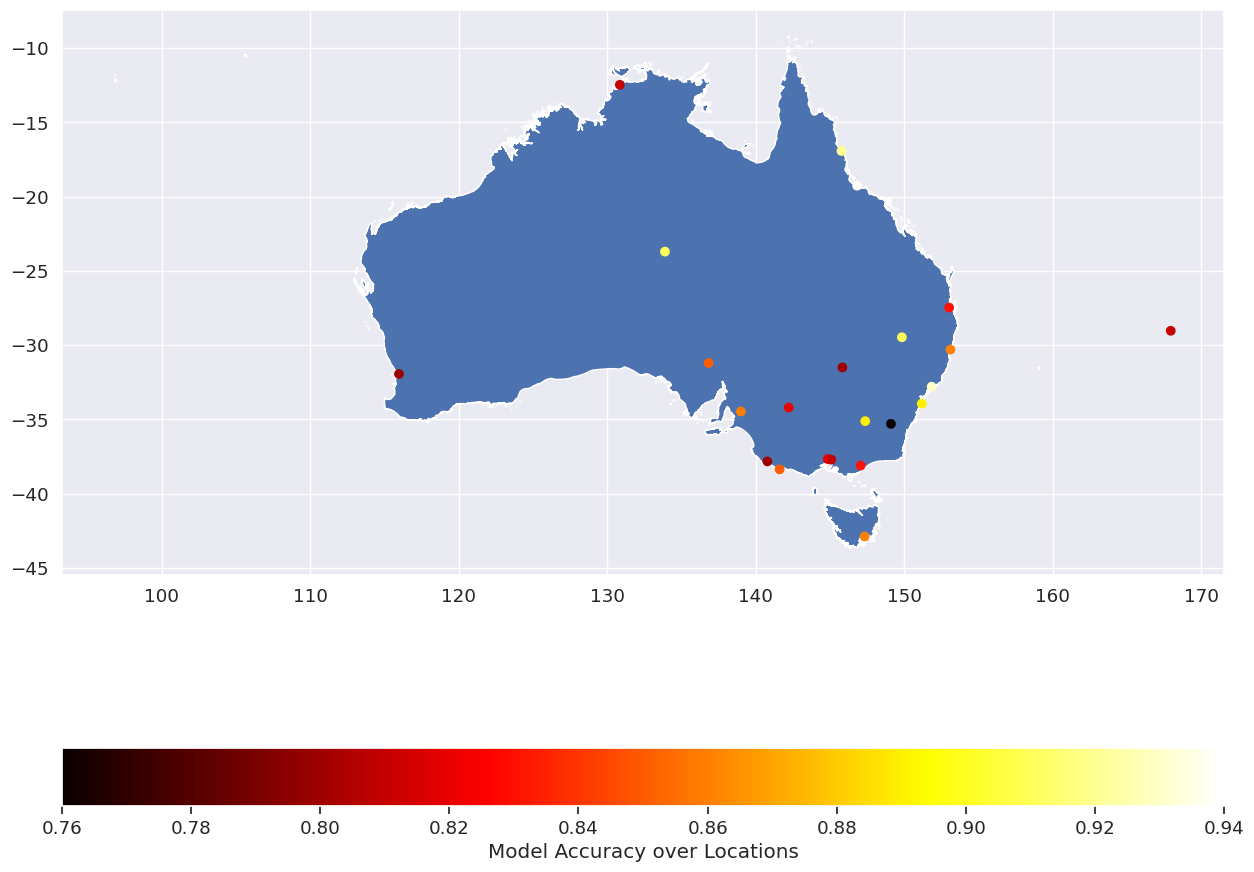

In [52]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 3.2 Visualization of Random Forest Precision Score

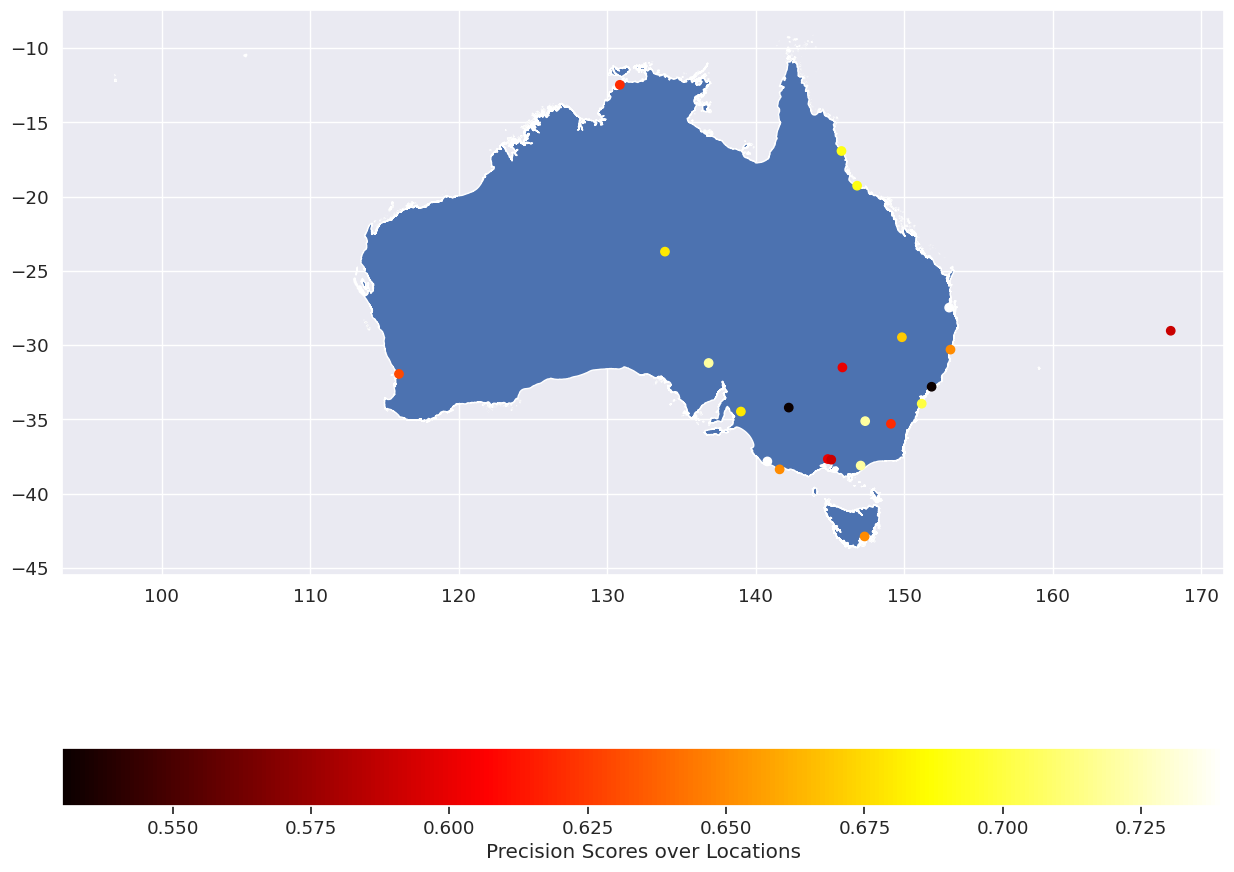

In [53]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 3.3 Visualization of Random Forest Recall Score

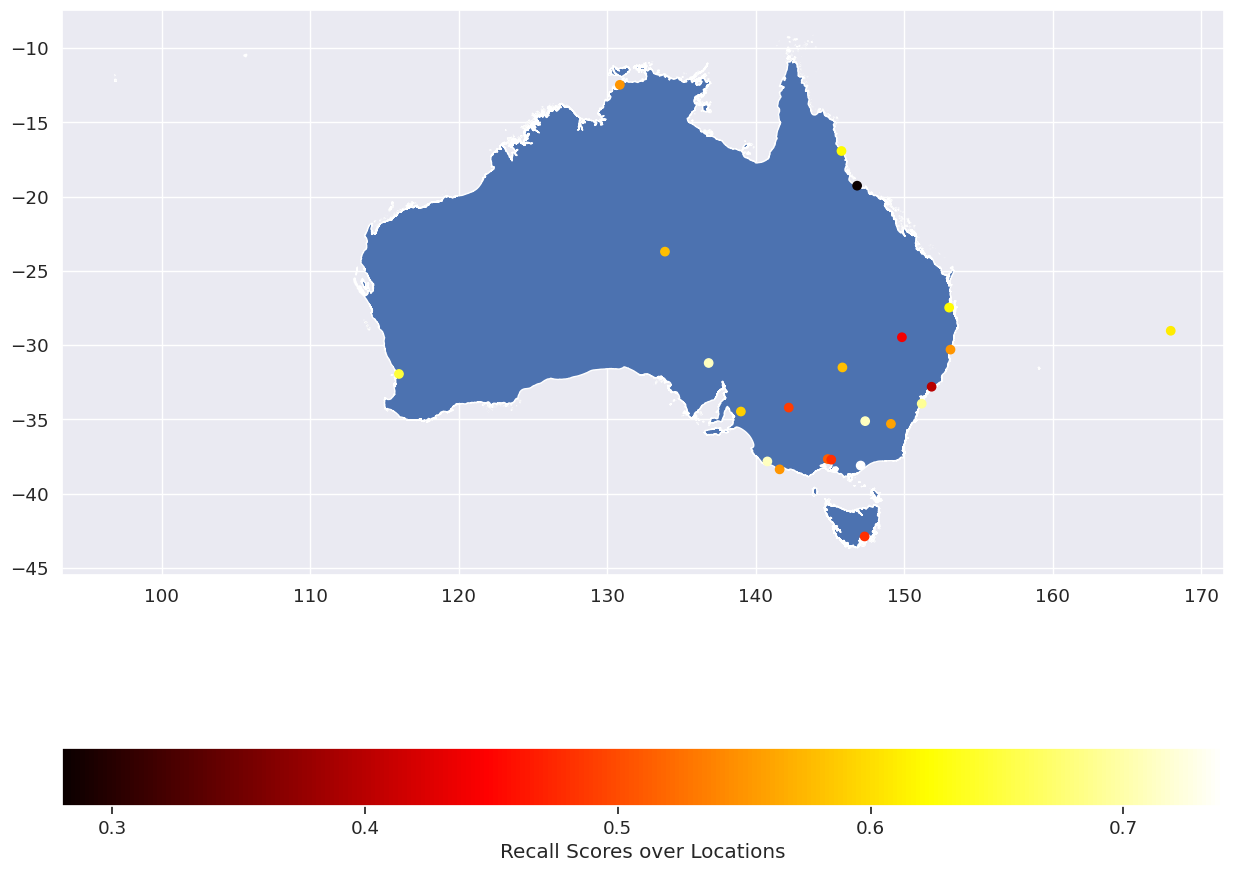

In [54]:
ax = gdf.plot(figsize=(15, 15))

results_rfc_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 3.4 Analysis for locations with best accuracy scores

In [55]:
best_locations = results_rfc_loc[results_rfc_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [56]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [57]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

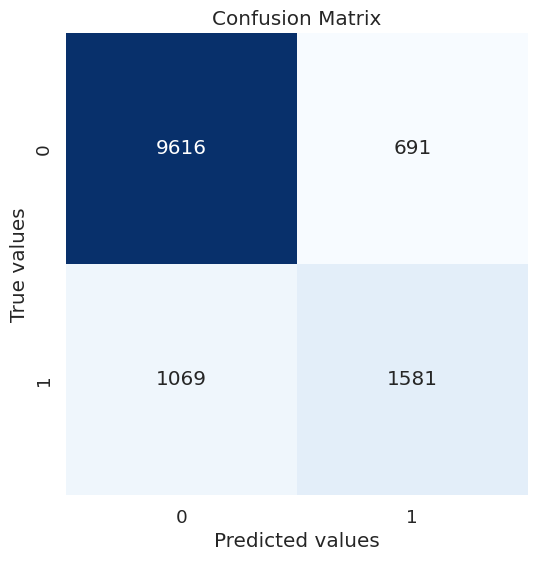

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92     10307
         1.0       0.70      0.60      0.64      2650

    accuracy                           0.86     12957
   macro avg       0.80      0.76      0.78     12957
weighted avg       0.86      0.86      0.86     12957

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.864


In [58]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

### 3.5 Analysis for locations with best precision scores

In [80]:
best_locations = results_rfc_loc[results_rfc_loc.Precision >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [81]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [82]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

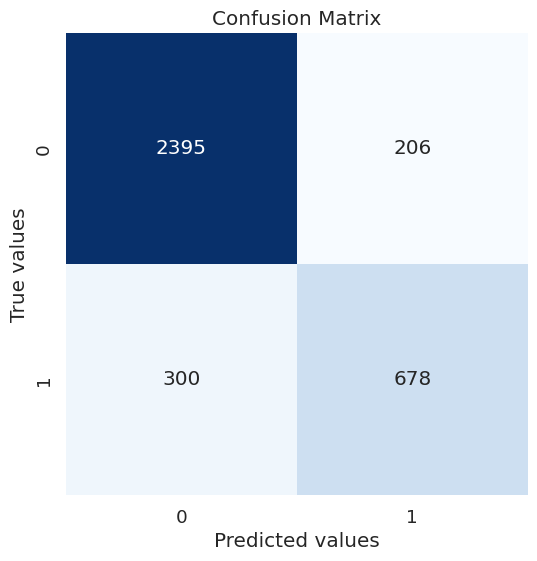

-------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      2601
         1.0       0.77      0.69      0.73       978

    accuracy                           0.86      3579
   macro avg       0.83      0.81      0.82      3579
weighted avg       0.86      0.86      0.86      3579

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.859


In [83]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

### 3.6 Analysis for locations with best recall scores

In [63]:
best_locations = results_rfc_loc[results_rfc_loc.Recall >= 0.70]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [64]:
X_resampled,y_resampled = ros.fit_resample(X_train_best,y_train_best)

In [65]:
rfc.fit(X_resampled,y_resampled)

RandomForestClassifier(n_jobs=-1, random_state=321)

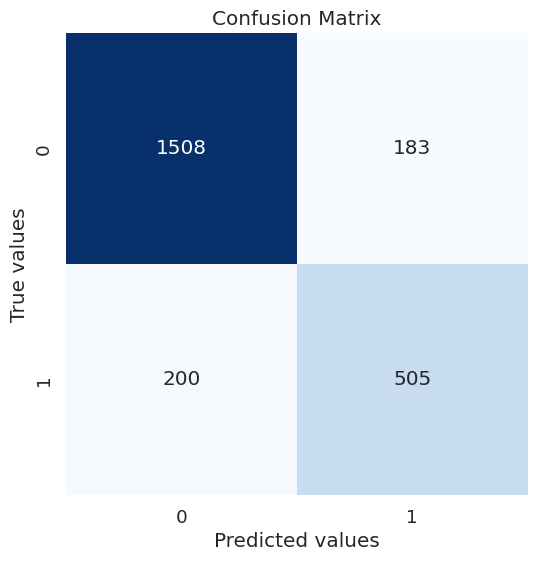

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      1691
         1.0       0.73      0.72      0.73       705

    accuracy                           0.84      2396
   macro avg       0.81      0.80      0.81      2396
weighted avg       0.84      0.84      0.84      2396

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.84


In [66]:
y_pred_rfc = rfc.predict(X_test_best)
y_pred_train_rfc = rfc.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_rfc, y_train_best, y_pred_train_rfc)

### Best results for all locations (from Random Forest Modelling Notebook)

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91     10663
         1.0       0.70      0.61      0.65      2882

    accuracy                           0.86     13545
   macro avg       0.80      0.77      0.78     13545
weighted avg       0.85      0.86      0.86     13545

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.86

### 4.  Map Visualization XGboosting with Random Undersampling

In [67]:
xgb = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.1)

In [68]:
df_xgb_loc = location_scores(rus, xgb)

In [69]:
# Create the GeoDataFrame by combining the DataFrame and GeoSeries
results_xgb_loc = gpd.GeoDataFrame(df_xgb_loc, geometry=gpd.points_from_xy([coord[1] for coord in coordinates], [coord[0] for coord in coordinates]))

### 4.1 Visualization of XGboosting Model Accuracy

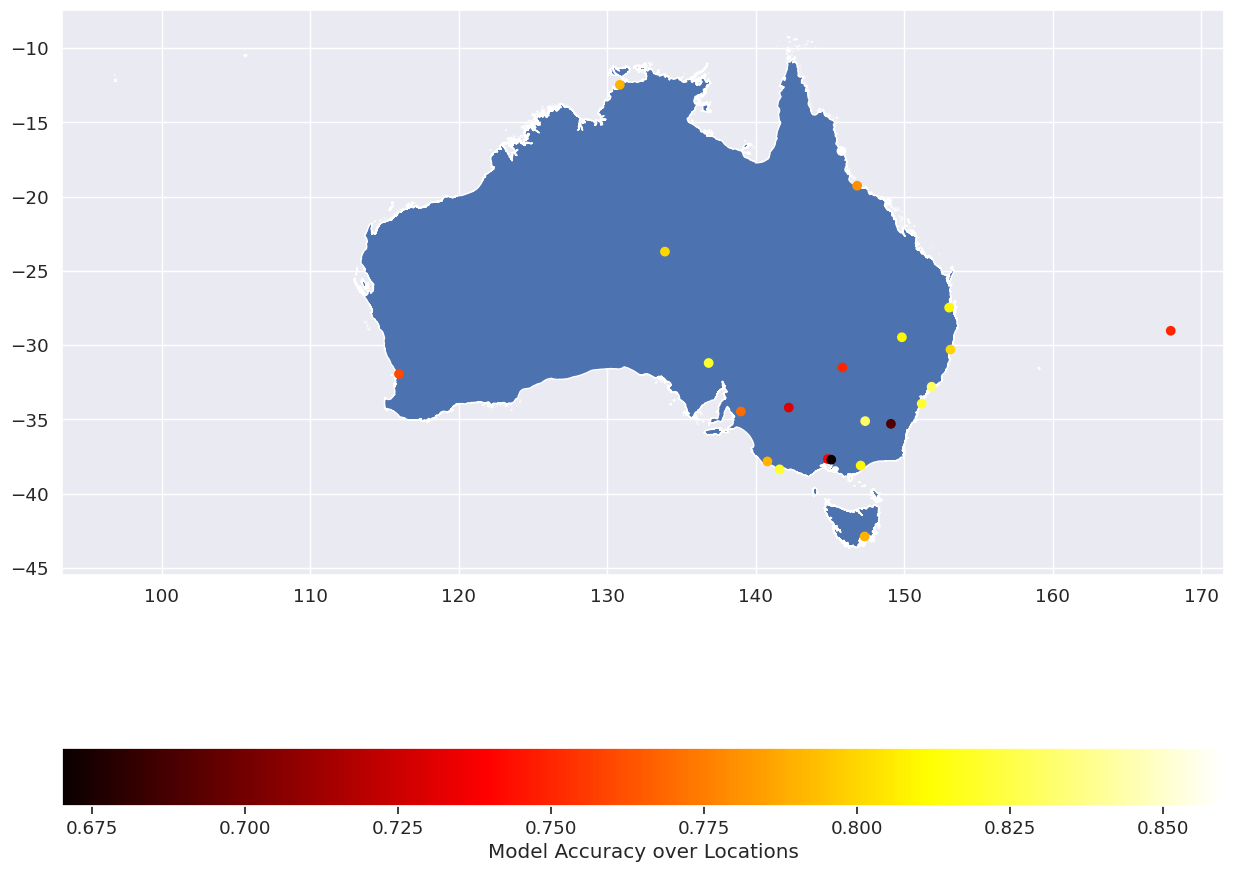

In [70]:
ax = gdf.plot(figsize=(15, 15))

results_xgb_loc.plot(
    column="Accuracy",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Model Accuracy over Locations", "orientation": "horizontal"},
);

### 4.2 Visualization of XGboosting Precision Scores

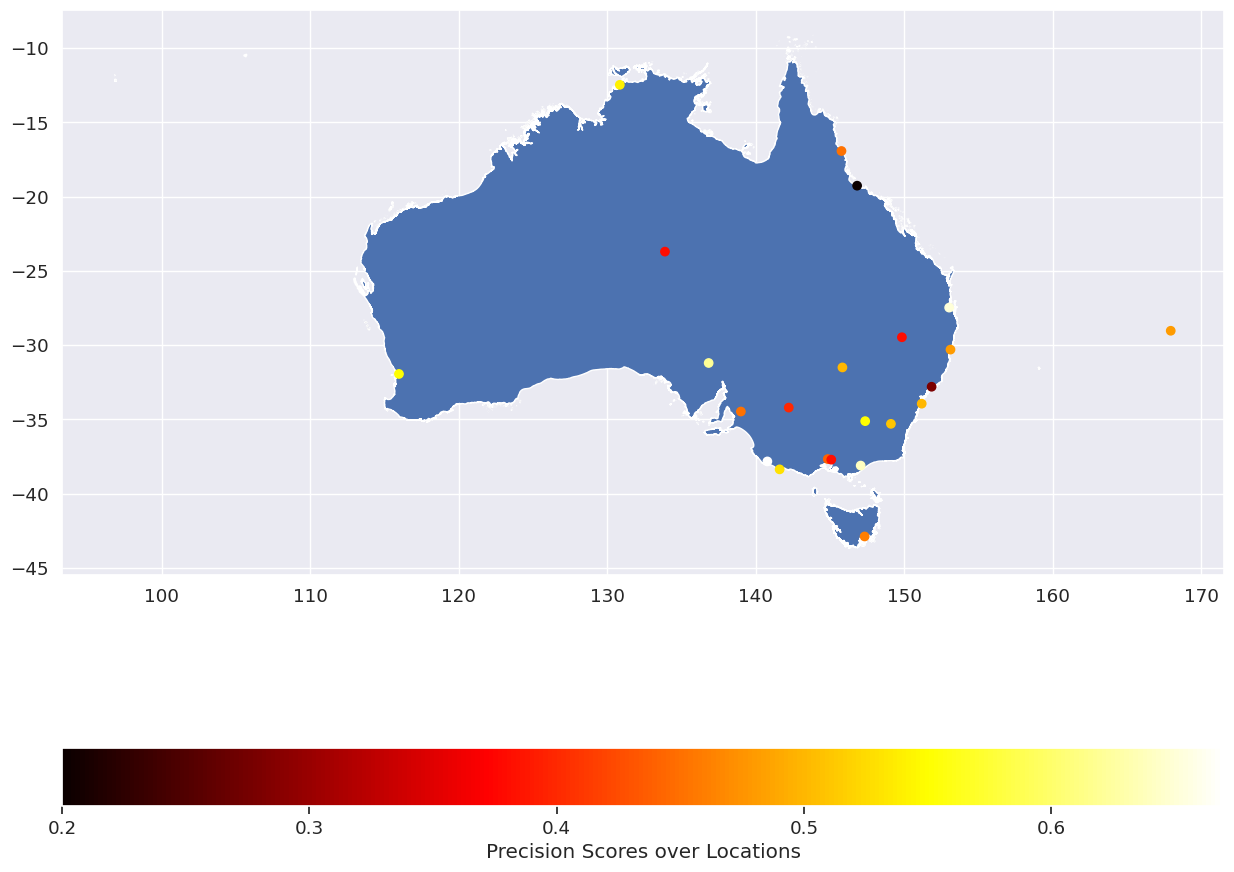

In [71]:
ax = gdf.plot(figsize=(15, 15))

results_xgb_loc.plot(
    column="Precision",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Precision Scores over Locations", "orientation": "horizontal"},
);

### 4.3 Visualization of XGboosting Recall Scores

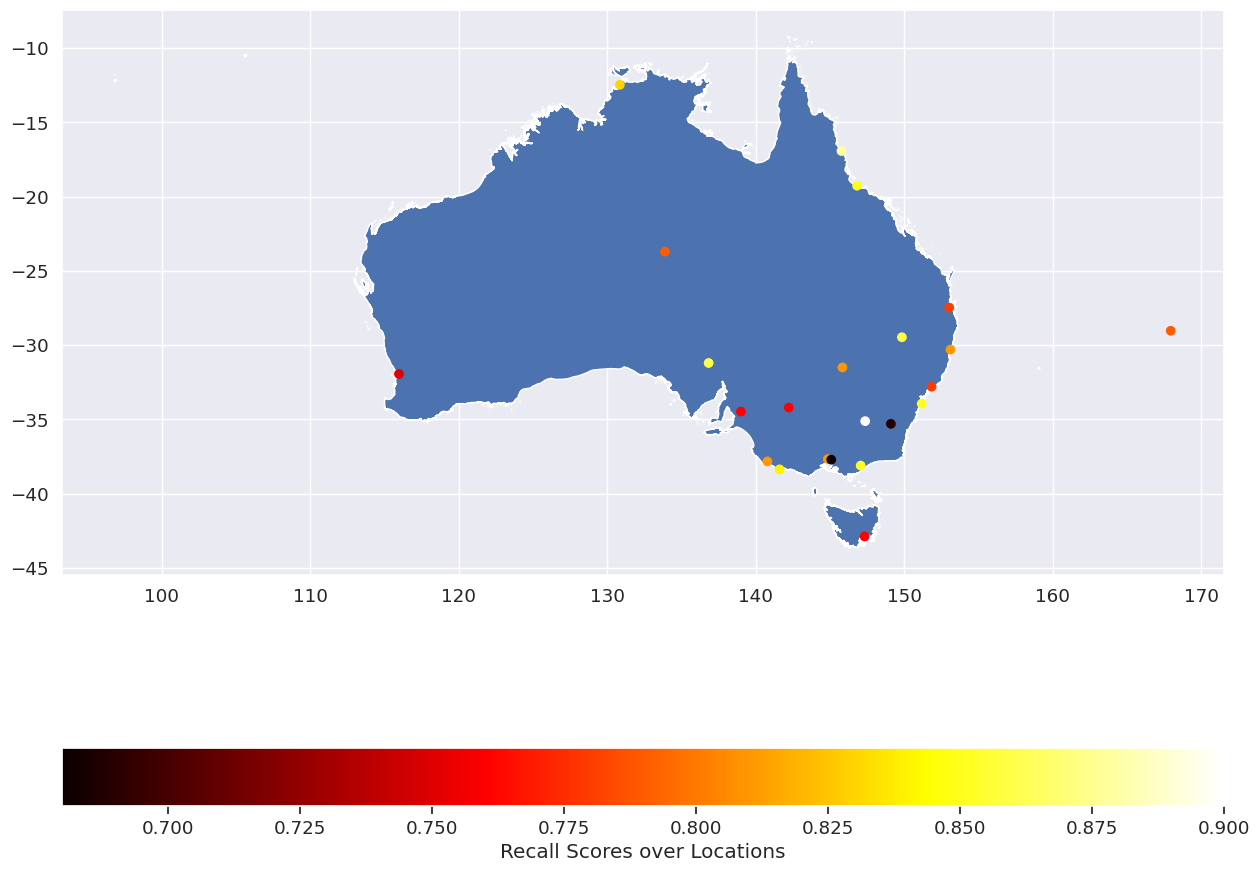

In [72]:
ax = gdf.plot(figsize=(15, 15))

results_xgb_loc.plot(
    column="Recall",
    ax=ax,
    legend=True,
    cmap='hot',
    legend_kwds={"label": "Recall Scores over Locations", "orientation": "horizontal"},
);

### 4.4 Analysis for locations with best accuracy scores

In [73]:
best_locations = results_xgb_loc[results_xgb_loc.Accuracy >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [74]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [75]:
xgb.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

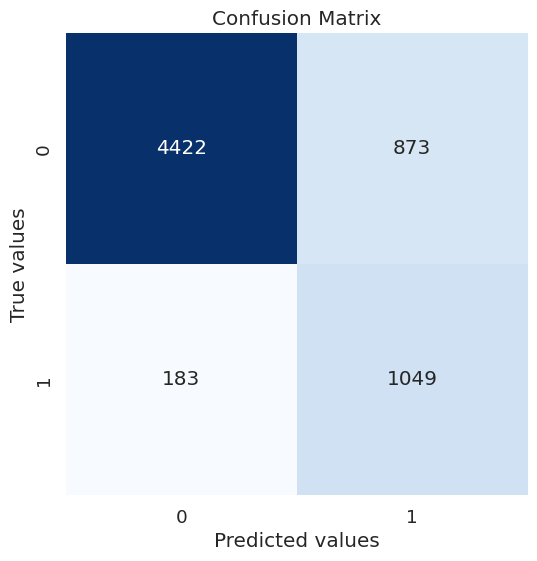

-------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89      5295
         1.0       0.55      0.85      0.67      1232

    accuracy                           0.84      6527
   macro avg       0.75      0.84      0.78      6527
weighted avg       0.88      0.84      0.85      6527

-------------------------
Accuracy Train Set: 0.889 Accuracy Test Set: 0.838


In [76]:
y_pred_xgb = xgb.predict(X_test_best)
y_pred_train_xgb = xgb.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_xgb, y_train_best, y_pred_train_xgb)

### 4.5 Analysis for locations with best precision scores

In [77]:
best_locations = results_xgb_loc[results_xgb_loc.Precision >= 0.60]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [78]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [85]:
xgb.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

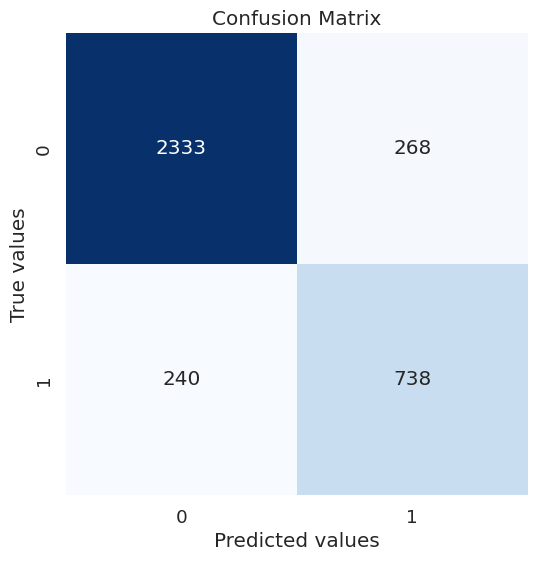

-------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      2601
         1.0       0.73      0.75      0.74       978

    accuracy                           0.86      3579
   macro avg       0.82      0.83      0.82      3579
weighted avg       0.86      0.86      0.86      3579

-------------------------
Accuracy Train Set: 0.983 Accuracy Test Set: 0.858


In [86]:
y_pred_xgb = xgb.predict(X_test_best)
y_pred_train_xgb = xgb.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_xgb, y_train_best, y_pred_train_xgb)

### 4.6 Analysis for locations with best recall scores

In [87]:
best_locations = results_xgb_loc[results_xgb_loc.Recall >= 0.80]
X_train_best, X_test_best, y_train_best, y_test_best = best_location_train_test_split(best_locations)

In [88]:
X_resampled,y_resampled = rus.fit_resample(X_train_best,y_train_best)

In [89]:
xgb.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

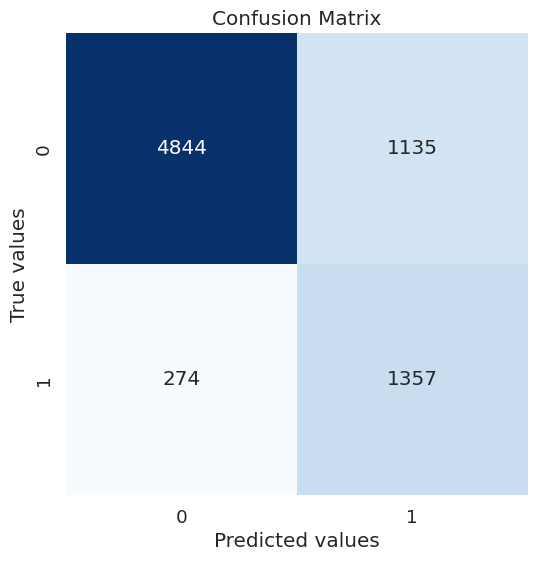

-------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      5979
         1.0       0.54      0.83      0.66      1631

    accuracy                           0.81      7610
   macro avg       0.75      0.82      0.77      7610
weighted avg       0.86      0.81      0.83      7610

-------------------------
Accuracy Train Set: 0.879 Accuracy Test Set: 0.815


In [90]:
y_pred_xgb = xgb.predict(X_test_best)
y_pred_train_xgb = xgb.predict(X_train_best)
confusion_matrix_classification_report(y_test_best, y_pred_xgb, y_train_best, y_pred_train_xgb)